In [1]:
from xml_tools import get_abstract_contents
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.cluster import KMeans
import pandas as pd
from sklearn.decomposition import PCA
import numpy as np
from scipy.spatial import distance_matrix
from sklearn import manifold
from tqdm import tqdm

In [2]:
import glob
from os import path



In [3]:
import spacy
nlp = spacy.load("en_core_web_lg")

In [4]:
xmls = glob.glob('../articles_from_tatiana/review_revenue_header_xml/*.xml')

xmls[:10]

['../articles_from_tatiana/review_revenue_header_xml/Zhang et al 2010.pdf.xml',
 '../articles_from_tatiana/review_revenue_header_xml/Pal et al. 2018.pdf.xml',
 '../articles_from_tatiana/review_revenue_header_xml/Gong et al 2018.pdf.xml',
 '../articles_from_tatiana/review_revenue_header_xml/Linh and Hong  2009-Channel coordination through a revenue sharing contract.pdf.xml',
 '../articles_from_tatiana/review_revenue_header_xml/Cao et al-2013-IJPE.pdf.xml',
 '../articles_from_tatiana/review_revenue_header_xml/Buratto et al - 2019.pdf.xml',
 '../articles_from_tatiana/review_revenue_header_xml/Hsueh 2014-Improving corporate social responsibility in a supply chain through a new revenue sharing contract.pdf.xml',
 '../articles_from_tatiana/review_revenue_header_xml/Lee and Rhee-2010-IJPE.pdf.xml',
 '../articles_from_tatiana/review_revenue_header_xml/Avinadav et al. 2019-IJPE.pdf.xml',
 '../articles_from_tatiana/review_revenue_header_xml/Shen et al-2019-POMS.pdf.xml']

In [5]:
article_abstract_dict = {path.basename(x).rsplit('.',2)[0]: get_abstract_contents(x) for x in xmls}

In [6]:
for k, v in article_abstract_dict.items():
    print(f'{k}: {v[:60]}... ({len(v)})\n')
#article_abstract_dict.__repr__()[:1000]

Zhang et al 2010: With the emergence of virtual market places, consignment sel... (1017)

Pal et al. 2018: Uncertainty is a major challenging factor in the marketing s... (1036)

Gong et al 2018: The information technology (IT) capabilities of third-party ... (1614)

Linh and Hong  2009-Channel coordination through a revenue sharing contract: This paper studies channel coordination through revenue shar... (772)

Cao et al-2013-IJPE: This paper develops a coordination mechanism for a supply ch... (1290)

Buratto et al - 2019: This paper investigates whether a supply chain can achieve c... (1354)

Hsueh 2014-Improving corporate social responsibility in a supply chain through a new revenue sharing contract: Due to the social and environmental impacts of industrial ac... (1450)

Lee and Rhee-2010-IJPE: Numerous studies have offered diverse contractual forms of a... (1761)

Avinadav et al. 2019-IJPE: Virtual products, such as mobile apps, 3D print files, e-mus... (1737)

Shen et al-2019-POM

In [7]:
Counter([min(len(v),500) for v in article_abstract_dict.values()])

Counter({500: 123, 0: 9, 339: 1, 422: 1, 368: 1, 433: 1})

In [8]:
article_abstract_dict = {k: v for k,v in article_abstract_dict.items() if len(v)>0}

In [9]:
bywords = {
    'rs','revenue share contract','revenue sharing contract','revenue sharing','rs contract','contract'
}
def spacy_clean_tokenizer(document, chunks=True):
    tokens = nlp(document)
    tokens = [token.lemma_ for token in (tokens.noun_chunks if chunks else tokens)  if (
        (chunks or token.is_stop == False) and 
        (chunks or token.is_punct == False) and 
        token.lemma_.strip()!= ''
    )]
    tokens = [ ' '.join([tk.lemma_ for tk in nlp(token) if not (tk.is_stop or tk.is_punct)]) 
              for token in tokens
             ]
    tokens = [tk for tk in tokens if len(tk) and tk not in bywords]
    return tokens

In [10]:
sorted(spacy_clean_tokenizer(list(article_abstract_dict.values())[1]))

['behavior',
 'chance factor',
 'condition',
 'demand uncertainty',
 'effect',
 'environment',
 'extra product',
 'feasibility',
 'flexible ordering policy',
 'graphical illustration',
 'key parameter',
 'major challenging factor',
 'manufacturer',
 'manufacturer',
 'manufacturer',
 'manufacturer Stackelberg revenue sharing contract',
 'marketing strategy',
 'model',
 'model',
 'model',
 'numerical example',
 'optimal decision',
 'penalty',
 'player',
 'propose model',
 'random yield',
 'random yield',
 'range',
 'salvage value',
 'sensitivity',
 'share',
 'stock',
 'stocking overstock risk',
 'study',
 'supplier',
 'supplier production',
 'supply chain',
 'uncertainty',
 'vertical Nash approach']

In [11]:
print([len(v.split()) for v in article_abstract_dict.values()])

[154, 159, 233, 115, 180, 195, 214, 242, 251, 231, 200, 144, 164, 261, 299, 158, 87, 253, 170, 111, 227, 98, 216, 132, 146, 51, 273, 181, 147, 55, 175, 102, 181, 151, 177, 216, 97, 176, 150, 125, 161, 220, 159, 156, 146, 124, 202, 243, 178, 189, 172, 167, 123, 183, 114, 141, 259, 275, 127, 216, 230, 174, 125, 197, 143, 223, 130, 159, 174, 184, 144, 213, 260, 220, 232, 191, 94, 214, 308, 235, 218, 198, 233, 161, 182, 99, 234, 144, 141, 132, 189, 196, 126, 93, 198, 188, 96, 193, 209, 55, 254, 107, 225, 196, 217, 197, 152, 182, 112, 213, 125, 103, 220, 97, 124, 115, 146, 197, 100, 248, 158, 227, 62, 83, 101, 144, 198]


In [12]:
tfidf_vectorizer = TfidfVectorizer(input = 'content', tokenizer = spacy_clean_tokenizer)

result = tfidf_vectorizer.fit_transform(iter(article_abstract_dict.values()))
result


<127x2350 sparse matrix of type '<class 'numpy.float64'>'
	with 3937 stored elements in Compressed Sparse Row format>

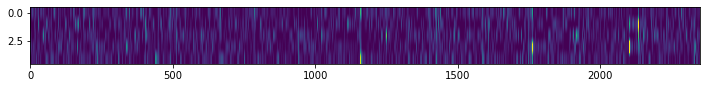

In [13]:
n_clusters=5
kmeans = KMeans(n_clusters=n_clusters,random_state=1015).fit(result)

kmeans.cluster_centers_.shape

import matplotlib.pyplot as plt
plt.figure(figsize=(12,4))
plt.imshow(kmeans.cluster_centers_,aspect=40,vmax=0.03)

In [14]:

mean_coord = kmeans.cluster_centers_.mean(axis=0)
mean_words = sorted(zip(mean_coord, tfidf_vectorizer.get_feature_names()),reverse=True)[:12]
mean_words

[(0.062082592724887364, 'retailer'),
 (0.05966898609343989, 'manufacturer'),
 (0.05932134675623506, 'supplier'),
 (0.05002665242081504, 'supply chain'),
 (0.03314918998829576, 'paper'),
 (0.029486867578095148, 'model'),
 (0.021763779408979857, 'result'),
 (0.019915187143787, 'product'),
 (0.019901976704274054, 'profit'),
 (0.019491523746144632, 'impact'),
 (0.01935248460090779, 'coordination'),
 (0.019318247652234895, 'demand')]

In [15]:
cc = kmeans.cluster_centers_
k = []
for i in range(n_clusters):
    k.append(sorted(zip(cc[i,:]-mean_coord, tfidf_vectorizer.get_feature_names()),reverse=True)[:12])

k[:2]

[[(0.03886682903359541, 'manufacturer'),
  (0.0329684112929088, 'firm'),
  (0.029441216574130277, 'vendor'),
  (0.023807326713361974, 'quality'),
  (0.021862618174779695, 'cooperative program'),
  (0.021524298124836465, 'app'),
  (0.01934979803573527, 'm&a'),
  (0.01886346585522016, 'consignment contract'),
  (0.018240431277012817, 'optimal value'),
  (0.017810145189827535, 'p2p'),
  (0.017158967021783402, 'investment'),
  (0.01700831403701611, 'consumer')],
 [(0.042876676690406984, 'supply chain'),
  (0.035549988385238984, 'buyer'),
  (0.027854070334067005, 'quick response'),
  (0.024185175447530922, 'insurance contract'),
  (0.022766940550321517, 'business'),
  (0.02119777546265274, 'product substitution'),
  (0.020709265057789833, 'decision sequence'),
  (0.019141810749959985, 'loss averse retailer'),
  (0.01875219513847424, 'er'),
  (0.01831536717841823, 'pareto improvement'),
  (0.01821213254023759, 'risk diversification contract'),
  (0.01775635030062708, 'coordination')]]

In [16]:
k50 = []
for i in range(n_clusters):
    k50.append(sorted(zip(cc[i,:]-mean_coord, tfidf_vectorizer.get_feature_names()),reverse=True)[:50])



In [17]:
k50[0]

[(0.03886682903359541, 'manufacturer'),
 (0.0329684112929088, 'firm'),
 (0.029441216574130277, 'vendor'),
 (0.023807326713361974, 'quality'),
 (0.021862618174779695, 'cooperative program'),
 (0.021524298124836465, 'app'),
 (0.01934979803573527, 'm&a'),
 (0.01886346585522016, 'consignment contract'),
 (0.018240431277012817, 'optimal value'),
 (0.017810145189827535, 'p2p'),
 (0.017158967021783402, 'investment'),
 (0.01700831403701611, 'consumer'),
 (0.01668752759456803, 'chain'),
 (0.015729602900530756, 'cooperation'),
 (0.015092460416181749, '3pl provider'),
 (0.01475416764611347, 'rq'),
 (0.014722745474060583, 'retail price'),
 (0.014323936027289567, 'return'),
 (0.013609158921971232, 'party'),
 (0.013397620606144163, 'r'),
 (0.013070668626570733, 'developer'),
 (0.012896488617382965, 'price discount mechanism'),
 (0.012751781190931108, 'manufacturer profit'),
 (0.012747216358209974, 'effect'),
 (0.012721532278448239, 'cc'),
 (0.012688567211573853, 'operation'),
 (0.01250398467386143, 

In [18]:
df = pd.concat([pd.DataFrame(data=v, columns= ['score','words']) for i,v in enumerate(k)],axis=0)
df['cluster'] = sum([[i]*12 for i in range(n_clusters)],[]) 
df = df[df.columns[::-1]]
df

,cluster,words,score
0,0,manufacturer,0.038867
1,0,firm,0.032968
2,0,vendor,0.029441
3,0,quality,0.023807
4,0,cooperative program,0.021863
5,0,app,0.021524
6,0,m&a,0.019350
7,0,consignment contract,0.018863
8,0,optimal value,0.018240
9,0,p2p,0.017810


In [19]:
df.groupby('cluster')['words'].apply( lambda w: '; '.join(w))

cluster
0    manufacturer; firm; vendor; quality; cooperati...
1    supply chain; buyer; quick response; insurance...
2    model; player; sc actor; agency model; disrupt...
3    supplier; retailer; wholesale price contract; ...
4    manufacturer; csr; wholesale price; platform; ...
Name: words, dtype: object

In [20]:
pwd

'/home/siegman/Documents/Shahar/years/y2021/t_and_t/code'

In [21]:
df.to_excel('revenue_review_tf_idf_cluster_main_words_5_clusters.xlsx', index=False)

In [22]:
kmeans.predict(result)


array([3, 2, 0, 4, 2, 0, 4, 2, 4, 4, 0, 1, 3, 4, 3, 3, 4, 2, 3, 1, 2, 0,
       1, 2, 3, 0, 4, 4, 0, 2, 1, 1, 4, 1, 3, 4, 1, 1, 0, 4, 0, 4, 0, 1,
       1, 0, 0, 2, 3, 0, 2, 0, 3, 0, 1, 1, 3, 2, 4, 4, 0, 0, 2, 0, 4, 0,
       1, 0, 4, 4, 3, 2, 2, 4, 0, 3, 1, 1, 4, 0, 3, 3, 4, 3, 3, 2, 4, 3,
       0, 2, 3, 2, 3, 1, 0, 1, 4, 3, 3, 0, 0, 3, 0, 3, 2, 0, 1, 3, 2, 4,
       2, 2, 3, 1, 3, 4, 3, 0, 1, 0, 3, 2, 4, 4, 4, 4, 4], dtype=int32)

In [31]:
cluster_affinity = np.array([3, 2, 0, 4, 2, 0, 4, 2, 4, 4, 0, 1, 3, 4, 3, 3, 4, 2, 3, 1, 2, 0,
       1, 2, 3, 0, 4, 4, 0, 2, 1, 1, 4, 1, 3, 4, 1, 1, 0, 4, 0, 4, 0, 1,
       1, 0, 0, 2, 3, 0, 2, 0, 3, 0, 1, 1, 3, 2, 4, 4, 0, 0, 2, 0, 4, 0,
       1, 0, 4, 4, 3, 2, 2, 4, 0, 3, 1, 1, 4, 0, 3, 3, 4, 3, 3, 2, 4, 3,
       0, 2, 3, 2, 3, 1, 0, 1, 4, 3, 3, 0, 0, 3, 0, 3, 2, 0, 1, 3, 2, 4,
       2, 2, 3, 1, 3, 4, 3, 0, 1, 0, 3, 2, 4, 4, 4, 4, 4],
      dtype=np.int32)

In [24]:
# cluster_affinity = np.array([5, 7, 2, 3, 3, 4, 3, 1, 3, 4, 5, 4, 5, 3, 5, 5, 2, 6, 5, 5, 1, 6,
#        5, 4, 5, 3, 1, 3, 3, 6, 5, 5, 5, 4, 5, 2, 5, 5, 4, 3, 1, 4, 4, 2,
#        4, 0, 6, 2, 7, 5, 4, 2, 2, 2, 4, 5, 2, 5, 4, 0, 2, 1, 4, 1, 7, 5,
#        3, 3, 7, 5, 3, 2, 5, 7, 7, 1, 3, 5, 1, 6, 2, 0, 5, 4, 0, 5, 4, 7,
#        3, 5, 4, 4, 2, 2, 5, 1, 3, 7, 3, 5, 5, 6, 6, 2, 1, 1, 2, 4, 7, 5,
#        5, 5, 2, 3, 5, 1, 5, 1, 5, 3, 5, 3, 5, 0, 7, 5, 6, 3, 5, 3, 4],
#       dtype=np.int32)

In [32]:
cluster_sets =[[x[1] for x in k] for k in k50]

In [33]:
article_tokens = {k: set(spacy_clean_tokenizer(v)) for k,v in article_abstract_dict.items()}

In [34]:
from collections import Counter
c = Counter()
for v in article_tokens.values():
    c.update(v)
    

In [35]:
len(c)

2347

In [39]:
def get_article_indetifiers():
    for (article_name, article_words), cluster  in \
            zip(article_tokens.items(), cluster_affinity):
        cluster_words = cluster_sets[cluster]
        joint_words = [word for word in cluster_words if word in article_words and c[word]>=3][:15]
        yield article_name, cluster, joint_words

In [40]:
cluster_summary = pd.DataFrame(
        data=list(get_article_indetifiers()), 
        columns = 'article_name, cluster, article_words'.split(', ')
    )

cluster_summary['article_words'] = cluster_summary.article_words.map(', '.join)
cluster_summary = cluster_summary.sort_values(['cluster','article_name'])
cluster_summary

,article_name,cluster,article_words
74,Avinadav T. 2020-IJPE,0,"manufacturer, investment, party, retailer, acc..."
100,Avinadav et al 2015a,0,"quality, consignment contract, investment, eff..."
51,Avinadav et al. 2017,0,"quality, consumer, party, effect"
45,Avinadav et al.- 2015b,0,"quality, consignment contract, effect, strateg..."
5,Buratto et al - 2019,0,"manufacturer, quality, cooperative program, co..."
...,...,...,...
78,Yao et al. 2008a,4,"manufacturer, demand variability, channel prof..."
59,Yao et al. 2008b,4,"manufacturer, compete retailer, demand variabi..."
82,Zhang et al 2019,4,manufacturer
69,check-Xu et al 2014-Coordinating a dual-channe...,4,"manufacturer, channel coordination, supply cha..."


In [41]:
cluster_summary.to_excel('revenue_review_tf_idf3_5_clusters.xlsx', index=False)

In [42]:
article_tokens['Xie et al 2017']

{'analysis',
 'background',
 'centralized decentralize dual channel close loop supply chain',
 'centralized decision',
 'change parameter valuation',
 'channel',
 'consideration',
 'decentralized decision',
 'feature',
 'influence',
 'manufacturing',
 'numeric example',
 'online offline dual channel',
 'online offline price',
 'optimal online offline price',
 'optimal profit',
 'recycle rate',
 'recycle rate fluctuation',
 'recycle revenue sharing ratio',
 'relationship',
 'revenue share mechanism',
 'revenue sharing ratio',
 'variable',
 'wholesale price',
 'wholesale price advertising investment'}

In [50]:
df2 = pd.DataFrame({'file_name': list(article_abstract_dict.keys()), 'cluster': kmeans.predict(result)})
df2=df2.sort_values(['cluster','file_name'])

In [51]:
word_series = df.groupby('cluster')['words'].apply( lambda w: '; '.join(w))
df2['words']=''
for cl,gr in df2.groupby('cluster'):
#     print(cl)
#     print(gr.columns)
    df2['words'][gr['words'].index[0]] = word_series[cl]

<ipython-input-51-14fec56918fb>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['words'][gr['words'].index[0]] = word_series[cl]


In [52]:
df2

,file_name,cluster,words
74,Avinadav T. 2020-IJPE,0,manufacturer; firm; vendor; quality; cooperati...
100,Avinadav et al 2015a,0,
51,Avinadav et al. 2017,0,
45,Avinadav et al.- 2015b,0,
5,Buratto et al - 2019,0,
...,...,...,...
78,Yao et al. 2008a,4,
59,Yao et al. 2008b,4,
82,Zhang et al 2019,4,
69,check-Xu et al 2014-Coordinating a dual-channe...,4,


In [ ]:
kmeans.cluster_centers_.shape


In [ ]:
df2.to_excel('revenue_review_tf_idf_cluster_contents3_5_clusters.xlsx',sheet_name='clusters', index=False)

In [ ]:
pd.__version__

In [ ]:
cluster_centers_pca = PCA()
cluster_centers_pca.fit(kmeans.cluster_centers_)

In [ ]:
np.round(np.cumsum(cluster_centers_pca.explained_variance_ratio_),3)

In [ ]:
cluster_centers_pca.components_ 

In [ ]:
cluster_centers_pca = PCA(2)
emb = cluster_centers_pca.fit_transform(kmeans.cluster_centers_)

In [ ]:
plt.plot(emb[:,0], emb[:,1],'.')

for i,r in enumerate(emb):
    plt.text(r[0],r[1],str(i))

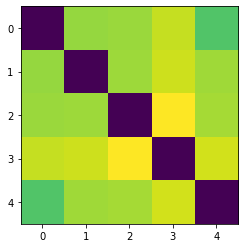

In [47]:
plt.imshow(distance_matrix(kmeans.cluster_centers_, kmeans.cluster_centers_))

In [ ]:
np.round(distance_matrix(kmeans.cluster_centers_, kmeans.cluster_centers_).mean(axis=0),3)

In [43]:

mds = manifold.MDS(n_components=2, dissimilarity="euclidean", random_state=6)
results = mds.fit(kmeans.cluster_centers_)

coords = results.embedding_


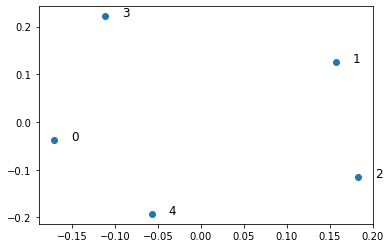

In [44]:
plt.plot(coords[:,0], coords[:,1],'o')

for i,r in enumerate(coords):
    plt.text(r[0]+0.02,r[1],str(i),fontsize=12)

In [45]:
result.shape

(127, 2350)

In [46]:
point_coord = []
for cl in range(8):
    points = result[cluster_affinity==cl,:] - kmeans.cluster_centers_[i,:]
    
    points2d = mds.fit(points).embedding_ + coords[i,:]
    point_coord.append(points2d)

ValueError: Found array with 0 sample(s) (shape=(0, 2350)) while a minimum of 1 is required.

In [ ]:
point_stats = []
for cl in range(8):
    points_dist = distance_matrix(result[cluster_affinity==cl,:].todense(),kmeans.cluster_centers_)
    points_dist = (points_dist**2).mean(axis=0)
    point_stats.append(points_dist)

In [ ]:
plt.imshow(np.vstack(point_stats))

In [ ]:
np.round(np.vstack(point_stats),3)

In [ ]:
import matplotlib.cm as cm

In [ ]:

for i,r in enumerate(coords):
    plt.plot(coords[i,0], coords[i,1],'o',color = cm.tab20(i))
    plt.plot(coords[i,0], coords[i,1],'d',color = cm.tab20(i))

    plt.plot(point_coord[i][:,0], point_coord[i][:,1],'.',color = cm.tab20(i))

In [ ]:
points2d

In [ ]:
result[cluster_affinity==2,:].todense().shape

### The clustering below is based on the community algorithm and was copy-pasted from cluster_and_draw_rr.ipynb

In [59]:
community_partition = {'Yang Lou and Zhang-2018': 0, 'Fang et al. 2016': 7, 'Wang 2006': 2, 'Lin et al. 2010': 3, 'Yao et al. 2008b': 7, 'Dana and  Spier 2001-Revenue Sharing and Vertical Control in the Video Rental Industry': 3, 'Wang and Shin 2014': 0, 'check-Li et al 2009-Supply chain coordination and decision making under consignment contract with revenue sharing': 7, 'RAZA 2018': 3, 'He et al 2017': 6, 'Choi and He-2019': 3, 'Cachon et al-2005': 3, 'Gerchak and Wang 2004-full version': 3, 'Lee and Rhee-2010-IJPE': 3, 'Wang et al 2012 (1)': 6, 'van der Veen and Venugopal 2005-Using Revenue Sharing to Create Win-Win in the Video Rental Supply Chain': 3, 'Becker-Peth and Thonemann 2016-Reference points in revenue sharing contracts—How to design optimal': 1, 'Dong et al 2016': 7, 'Sarathi et al 2014-An integrated revenue sharing and quantity discounts contract': 3, 'Zhang et al 2019': 0, 'Ru and Wang 2010- consignment contracts': 7, 'Palsule-Desai 2013-Supply chain coordination using revenue-dependent revenue': 1, 'Wang and Shin-2015': 0, 'Cai et al 2012- Exclusive Channels and Revenue Sharing in a complementary goods market': 0, 'check-Yao et al 2008-Manufacturer’s revenue-sharing contract and retail competition': 7, 'Govindan and Malomfalean 2019': 0, 'Yang and Chen 2017-Retailer-driven carbon emission abatement with consumer': 0, 'Avinadav et al 2015a': 6, 'Hu et al 2017': 1, 'Giannoccaro and pontrandolfo-2009': 3, 'Hsueh 2014-Improving corporate social responsibility in a supply chain through a new revenue sharing contract': 3, 'Giri and Bardhan-2012': 1, 'Liu and Wang-2019': 1, 'Yang et al 2018-Supplier encroachment under nonlinear pricing with imperfect substitutes': 0, 'Avinadav et al.- 2015b': 6, 'Giri et al 2017': 3, 'Krishnan and Winter 2011-On the role of revenue-sharing contracts in supply chains': 1, 'Krylatov et al. -2016 (לא קשור)': 3, 'Shen et al-2019-POMS': 0, 'Gerchak and Khmelnitsky 2003': 3, 'Chen et al 2011-On channel coordination through revenue-sharing contracts with price and shelf-space dependent demand': 1, 'Sarker 2014': 6, 'Zhang et al 2019b': 0, 'El Ouardighi and Kim 2010-Supply quality management with wholesale price and revenue-sharing contracts under horizontal competition': 1, 'Saraswati and Hanaoka 2014-Airport–airline cooperation under commercial revenue sharing': 1, 'Avinadav et al-2019-IJPE': 6, 'Hu et al. 2019': 6, 'Bellantuono et al 2009-The implications of joint adoption of revenue sharing and advance booking discount': 3, 'Bai et al 2004-revenue sharing and control rights': 7, 'Qin and Yang 2008': 7, 'Cao et al-2013-IJPE': 1, 'check-Xu et al 2014-Coordinating a dual-channel supply chain with risk-averse': 0, 'Heese and Kemahlioglu-Ziya 2014': 3, 'check-Wang et al 2004-Channel Performance under Consignment Contract with Revenue Sharing': 7, 'Zhao et al-2016-JORS': 3, 'Mai et al 2017': 0, 'Gerchak et al-2007': 6, 'Moon and Feng-2017': 1, 'Wang et al-2013b': 7, 'Panda et al 2017': 3, 'Heese and Kemahlıoğlu-Ziya 2016-Don’t ask don’t tell-Sharing revenues with a dishonest retailer': 3, 'Hou et al 2017': 1, 'Pal et al. 2018': 3, 'Linh and Hong  2009-Channel coordination through a revenue sharing contract': 3, 'Kunter 2012-Coordination via cost and revenue sharing in manufacturer–retailer channels': 1, 'Guan and Zhao 2010': 6, 'zhang et al. 2015': 3, 'van der Rhee et al 2010-A new revenue sharing mechanism for coordinating multi-echelon supply chains': 3, 'Kong et al. 2013': 1, 'Gong et al 2018': 6, 'Panda 2014-Coordination of a socially responsible supply chain using revenue sharing contract': 3, 'Sheu 2011-Marketing-driven channel coordination with revenue-sharing contracts': 1, 'Jin et al-2015-EJOR': 7, 'Cai-2010-channel selection and coordination': 0, 'Giovanni 2014': 1, 'check-Hu et al 2016-Three-echelon supply chain coordination': 1, 'Tan_Carrillo-2017': 0, 'Lu et al 2017': 6, 'Xiao and Xu-2018-POMS': 0, 'Gupta and Weerawat-2006-EJOR': 3, 'Corbett 2001': 3, 'Jiang 2012': 7, 'Xiao et al 2011-Coordinating a supply chain with a quality assurance policy via a revenue sharing contract': 1, 'Jorgensen et al-2003-EJOR': 1, 'Saha 2013-CCRS': 1, 'Giannoccaro and pontrandolfo-2004-IJPE': 3, 'Li et al- 2016-WCRS': 7, 'Li_et_al-2015': 3, 'Yang et al. 2015': 3, 'Wang et al 2012-Three revenue-sharing variants their significant performance differences under systemparameter uncertainties': 1, 'Yao et al. 2008a': 7, 'Hua et al-2011-Omega': 1, 'Lim et al 2015': 7, 'Feng et al 2017': 0, 'Xie et al 2017': 0, 'Hu et al-2013-IJPE': 3, 'Feng et al 2014-Revenue-sharing contracts in an N-stage supply chain with reliability consideration': 1, 'Zhao and Wu 2011-coordination of agri-food chain with revenue sharing contract and stochastic demand': 4, 'Vafa Arani et al 2016-A revenue-sharing option contract toward coordination of supply chains': 1, 'Yang et al 2017-The role of revenue sharing and first-mover advantage in emission': 0, 'Chakraborty et al 2018': 1, 'Hou et al 2009-Achieving better coordination through revenue sharing and bargaining': 1, 'Xiao et al 2017': 3, 'de Matta et al 2014': 7, 'Zhang et al 2010': 7, 'Hu-Li-2012': 7, 'Avinadav et al. 2020-IJPR': 6, 'Buratto et al - 2019': 6, 'Govindan and Popiuc 2014-Reverse supply chain coordination by revenue sharing contract': 1, 'check-Hu and Feng 2017-Optimization and coordination of supply chain with revenue sharing': 1, 'Katok and Wu-2009-Contracting_in_Supply_Chains_A_Laboratory_Investigation': 3, 'check-Pan et al 2010-Revenue-sharing versus wholesale price mechanisms under different channel structures': 1, 'Chakraborty et al 2015-Coordination and competition in a common retailer': 7, 'Wen et al. 2018': 3, 'Liu li et al 2017': 1, 'Zhang 2015-Coordinating a supply chain for deteriorating items with a revenue sharing': 1, 'Chen et al 2011': 1, 'Khouja et al-2010-IJPE': 1, 'Chen et al 2010': 6, 'Avinadav T. 2020-IJPE': 6, 'Adida and Ratisoontorn-2011': 7, 'Avinadav et al. 2017': 6, 'Giovanni and Roselli 2012': 1, 'Tan_et_al-2016': 1, 'De Giovanni et al 2019': 6, 'Avinadav et al. 2019-IJPE': 6, 'Cai  et al 2017-Flexible contract design for VMI supply chain with service-sensitive demand': 1, 'Liu et al-2009': 3, 'Zao and Shi 2011': 7, 'de Matt et al 2017': 7, 'Koulamas 2006-full version': 5, 'Shen 2018': 0, 'Wang et al. 2013': 7, 'Seifbarghy et al. 2015': 1, 'Lu et al-2018-EJOR': 0, 'Zhang et al 2010-Revenue sharing with multiple airlines and airports': 1, 'Yan et al-2018-EJOR': 0, 'Chen et al 2017': 7, 'Heydari et al 2018': 0}

In [49]:
df2.columns

NameError: name 'df2' is not defined

In [60]:
cluster_summary['community'] = cluster_summary.article_name.map(lambda c: 'ABCDEFGHIJ'[community_partition[c]] if c in community_partition else '')

In [61]:
cluster_summary.to_excel('revenue_review_tf_idf3_5_clusters.xlsx', index=False)

In [64]:
gg = cluster_summary.groupby(['cluster','community'])['article_name'].count()

In [71]:
gg.reset_index().sort_values(['cluster','article_name'], ascending=[True, False])

,cluster,community,article_name
1,0,B,10
3,0,G,9
2,0,D,6
0,0,A,2
4,0,H,2
7,1,B,6
8,1,D,5
9,1,G,4
10,1,H,3
5,1,,1


In [ ]:
gg.sort_values()